In [170]:
import pywt
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

### Chirp signal:

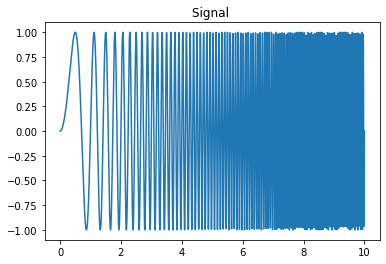

In [171]:
x = np.linspace(0, 10, num=2048)
dx = np.diff(x).mean()
chirp_signal =  np.sin(2 * np.pi * x**2)
    
fig, ax = plt.subplots()
ax.set_title("Signal ")
ax.plot(x,chirp_signal)

In [294]:
peaks = scipy.signal.find_peaks(chirp_signal,prominence=1)[0]
s0 = np.diff(x[peaks]).mean()
s1 = max(x)
s_chirp = np.linspace(s0,s1,num=100)

w_chirp,freqs_chirp = pywt.cwt(chirp_signal,s_chirp,'cmor')
periods_chirp = 1./freqs_chirp
amp_wchirp= np.real(w_chirp*np.conjugate(w_chirp))

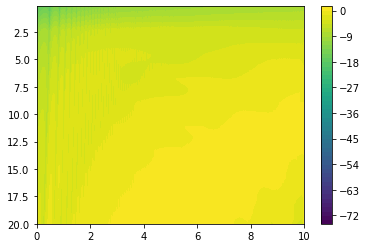

In [293]:
fig,ax = plt.subplots()
#ax = fig.add_subplot(2,1,1)
cs = ax.contourf(x,periods_chirp,np.log(amp_wchirp),levels=50)
ax.invert_yaxis()
plt.colorbar(cs)

### Modulated tidal signal:

In [175]:
t = np.linspace(0,30,10000)
dt = np.diff(t)[0]
ft = 2#/(24*3600)
sig_tide = np.cos(ft*2*np.pi*t)
noise = np.random.normal(0,0.1,sig_tide.shape)
fl = 1/10#(30*24*3600)
mod = np.cos(fl*np.pi*t)
signal = sig_tide*mod

Text(0.5, 1.0, 'Modulated signal')

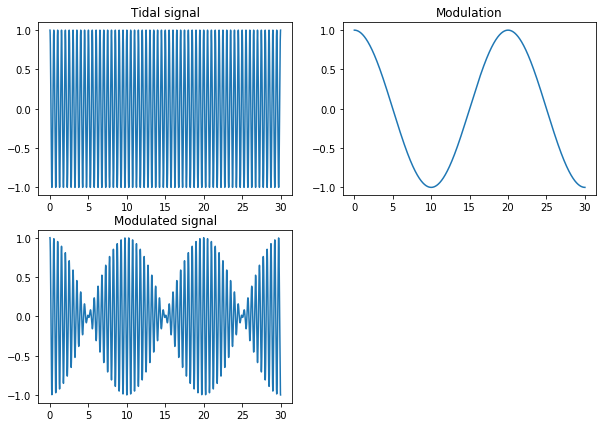

In [176]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2,2,1)
ax.plot(t,sig_tide)
ax.set_title('Tidal signal')
ax = fig.add_subplot(2,2,2)
ax.plot(t,mod)
ax.set_title('Modulation')
ax = fig.add_subplot(2,2,3)
ax.plot(t,signal)
ax.set_title('Modulated signal')

In [177]:
peaks = scipy.signal.find_peaks(signal,prominence=1)[0]
s0 = np.around(np.diff(t[peaks]).mean(),decimals=1)/2#6/4*dt
s1 = int(max(t)/2)-1
s = np.linspace(s0,s1,num=100)

In [178]:
w,freqs = pywt.cwt(signal,s,'morl')
periods = 1./freqs
amp_w = np.real(w*np.conjugate(w))

In [179]:
amp = xr.DataArray(amp_w, coords = [s,t],dims=['scales','time'])
diff_amp = amp.differentiate(coord='scales')
diff2 = diff_amp.differentiate(coord='scales')


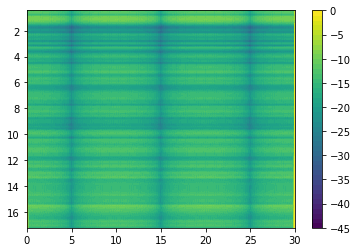

In [180]:
fig,ax = plt.subplots()
#ax = fig.add_subplot(2,1,1)
cs = ax.contourf(t,periods,np.log(amp_w),levels=50)
ax.invert_yaxis()
plt.colorbar(cs)

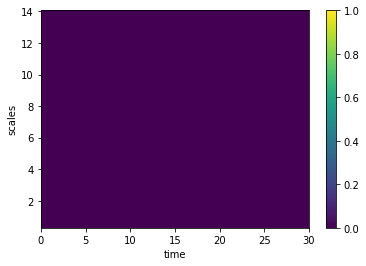

In [181]:
smax = []#np.full_like(amp,np.nan)
pmax = []
count = np.zeros_like(amp_w)
#tst = scipy.signal.find_peaks(amp.isel(time=1))[0]
for i,T in enumerate(amp.time.values[:-2]):
    I = scipy.signal.find_peaks(amp.sel(time=T),prominence=0.1)[0]
#    smax.append(s[I])
#    pmax.append(periods[I])
    count[I,i] = 1.

count = xr.DataArray(count,coords=[s,t],dims=['scales','time'])

count.plot()

[40 70 80 90]


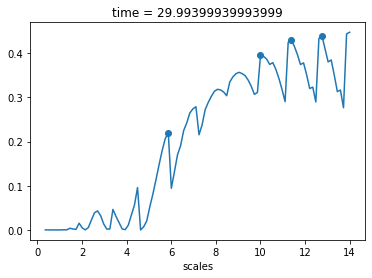

In [182]:
p = scipy.signal.find_peaks(amp.sel(time=T),prominence=0.1)[0]
print(p)
amp.sel(time=T).plot()
plt.scatter(s[p],amp.sel(time=T)[p])

In [215]:
from __future__ import division

import numpy as np

__all__ = ['demo_signal']

_implemented_signals = [
    'Blocks',
    'Bumps',
    'HeaviSine',
    'Doppler',
    'Ramp',
    'HiSine',
    'LoSine',
    'LinChirp',
    'TwoChirp',
    'QuadChirp',
    'MishMash',
    'WernerSorrows',
    'HypChirps',
    'LinChirps',
    'Chirps',
    'Gabor',
    'sineoneoverx',
    'Piece-Regular',
    'Piece-Polynomial',
    'Riemann']


def demo_signal(name='Bumps', n=None):
    """Simple 1D wavelet test functions.
    This function can generate a number of common 1D test signals used in
    papers by David Donoho and colleagues (e.g. [1]_) as well as the wavelet
    book by Stéphane Mallat [2]_.
    Parameters
    ----------
    name : {'Blocks', 'Bumps', 'HeaviSine', 'Doppler', ...}
        The type of test signal to generate (`name` is case-insensitive). If
        `name` is set to `'list'`, a list of the avialable test functions is
        returned.
    n : int or None
        The length of the test signal. This should be provided for all test
        signals except `'Gabor'` and `'sineoneoverx'` which have a fixed
        length.
    Returns
    -------
    f : np.ndarray
        Array of length ``n`` corresponding to the specified test signal type.
    References
    ----------
    .. [1] D.L. Donoho and I.M. Johnstone.  Ideal spatial adaptation by
           wavelet shrinkage. Biometrika, vol. 81, pp. 425–455, 1994.
    .. [2] S. Mallat. A Wavelet Tour of Signal Processing: The Sparse Way.
           Academic Press. 2009.
    Notes
    -----
    This function is a partial reimplementation of the `MakeSignal` function
    from the [Wavelab](https://statweb.stanford.edu/~wavelab/) toolbox. These
    test signals are provided with permission of Dr. Donoho to encourage
    reproducible research.
    """
    if name.lower() == 'list':
        return _implemented_signals

    if n is not None:
        if n < 1 or (n % 1) != 0:
            raise ValueError("n must be an integer >= 1")
        t = np.arange(1/n, 1 + 1/n, 1/n)

    # The following function types don't allow user-specified `n`.
    n_hard_coded = ['gabor', 'sineoneoverx']

    name = name.lower()
    if name in n_hard_coded and n is not None:
        raise ValueError(
            "Parameter n must be set to None when name is {}".format(name))
    elif n is None and name not in n_hard_coded:
        raise ValueError(
            "Parameter n must be provided when name is {}".format(name))

    if name == 'blocks':
        t0s = [.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]
        hs = [4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2]
        f = 0
        for (t0, h) in zip(t0s, hs):
            f += h * (1 + np.sign(t - t0)) / 2
    elif name == 'bumps':
        t0s = [.1, .13, .15, .23, .25, .4, .44, .65, .76, .78, .81]
        hs = [4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 5.1, 4.2]
        ws = [.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]
        f = 0
        for (t0, h, w) in zip(t0s, hs, ws):
            f += h / (1 + np.abs((t - t0) / w))**4
    elif name == 'heavisine':
        f = 4 * np.sin(4 * np.pi * t) - np.sign(t - 0.3) - np.sign(0.72 - t)
    elif name == 'doppler':
        f = np.sqrt(t * (1 - t)) * np.sin(2 * np.pi * 1.05 / (t + 0.05))
    elif name == 'ramp':
        f = t - (t >= .37)
    elif name == 'hisine':
        f = np.sin(np.pi * (n * .6902) * t)
    elif name == 'losine':
        f = np.sin(np.pi * (n * .3333) * t)
    elif name == 'linchirp':
        f = np.sin(np.pi * t * ((n * .500) * t))
    elif name == 'twochirp':
        f = np.sin(np.pi * t * (n * t)) + np.sin((np.pi / 3) * t * (n * t))
    elif name == 'quadchirp':
        f = np.sin((np.pi / 3) * t * (n * t**2))
    elif name == 'mishmash':  # QuadChirp + LinChirp + HiSine
        f = np.sin((np.pi / 3) * t * (n * t**2))
        f += np.sin(np.pi * (n * .6902) * t)
        f += np.sin(np.pi * t * (n * .125 * t))
    elif name == 'wernersorrows':
        f = np.sin(np.pi * t * (n / 2 * t**2))
        f = f + np.sin(np.pi * (n * .6902) * t)
        f = f + np.sin(np.pi * t * (n * t))
        pos = [.1, .13, .15, .23, .25, .40, .44, .65, .76, .78, .81]
        hgt = [4, 5, 3, 4, 5, 4.2, 2.1, 4.3, 3.1, 5.1, 4.2]
        wth = [.005, .005, .006, .01, .01, .03, .01, .01, .005, .008, .005]
        for p, h, w in zip(pos, hgt, wth):
            f += h / (1 + np.abs((t - p) / w))**4
    elif name == 'hypchirps':  # Hyperbolic Chirps of Mallat's book
        alpha = 15 * n * np.pi / 1024
        beta = 5 * n * np.pi / 1024
        t = np.arange(1.001, n + .001 + 1) / n
        f1 = np.zeros(n)
        f2 = np.zeros(n)
        f1 = np.sin(alpha / (.8 - t)) * (0.1 < t) * (t < 0.68)
        f2 = np.sin(beta / (.8 - t)) * (0.1 < t) * (t < 0.75)
        m = int(np.round(0.65 * n))
        p = m // 4
        envelope = np.ones(m)  # the rinp.sing cutoff function
        tmp = np.arange(1, p + 1)-np.ones(p)
        envelope[:p] = (1 + np.sin(-np.pi / 2 + tmp / (p - 1) * np.pi)) / 2
        envelope[m-p:m] = envelope[:p][::-1]
        env = np.zeros(n)
        env[int(np.ceil(n / 10)) - 1:m + int(np.ceil(n / 10)) - 1] = \
            envelope[:m]
        f = (f1 + f2) * env
    elif name == 'linchirps':  # Linear Chirps of Mallat's book
        b = 100 * n * np.pi / 1024
        a = 250 * n * np.pi / 1024
        t = np.arange(1, n + 1) / n
        A1 = np.sqrt((t - 1 / n) * (1 - t))
        f = A1 * (np.cos(a * t**2) + np.cos(b * t + a * t**2))
    elif name == 'chirps':  # Mixture of Chirps of Mallat's book
        t = np.arange(1, n + 1)/n * 10 * np.pi
        f1 = np.cos(t**2 * n / 1024)
        a = 30 * n / 1024
        t = np.arange(1, n + 1)/n * np.pi
        f2 = np.cos(a * (t**3))
        f2 = f2[::-1]
        ix = np.arange(-n, n + 1) / n * 20
        g = np.exp(-ix**2 * 4 * n / 1024)
        i1 = slice(n // 2, n // 2 + n)
        i2 = slice(n // 8, n // 8 + n)
        j = np.arange(1, n + 1) / n
        f3 = g[i1] * np.cos(50 * np.pi * j * n / 1024)
        f4 = g[i2] * np.cos(350 * np.pi * j * n / 1024)
        f = f1 + f2 + f3 + f4
        envelope = np.ones(n)  # the rinp.sing cutoff function
        tmp = np.arange(1, n // 8 + 1) - np.ones(n // 8)
        envelope[:n // 8] = (
            1 + np.sin(-np.pi / 2 + tmp / (n / 8 - 1) * np.pi)) / 2
        envelope[7 * n // 8:n] = envelope[:n // 8][::-1]
        f = f*envelope
    elif name == 'gabor':  # two modulated Gabor functions in Mallat's book
        n = 512
        t = np.arange(-n, n + 1)*5 / n
        j = np.arange(1, n + 1) / n
        g = np.exp(-t**2 * 20)
        i1 = slice(2*n // 4, 2 * n // 4 + n)
        i2 = slice(n // 4, n // 4 + n)
        f1 = 3 * g[i1] * np.exp(1j * (n // 16) * np.pi * j)
        f2 = 3 * g[i2] * np.exp(1j * (n // 4) * np.pi * j)
        f = f1 + f2
    elif name == 'sineoneoverx':  # np.sin(1/x) in Mallat's book
        n = 1024
        i1 = np.arange(-n + 1, n + 1, dtype=float)
        i1[i1 == 0] = 1 / 100
        i1 = i1 / (n - 1)
        f = np.sin(1.5 / i1)
        f = f[512:1536]
    elif name == 'piece-regular':
        f = np.zeros(n)
        n_12 = int(np.fix(n / 12))
        n_7 = int(np.fix(n / 7))
        n_5 = int(np.fix(n / 5))
        n_3 = int(np.fix(n / 3))
        n_2 = int(np.fix(n / 2))
        n_20 = int(np.fix(n / 20))
        f1 = -15 * demo_signal('bumps', n)
        t = np.arange(1, n_12 + 1) / n_12
        f2 = -np.exp(4 * t)
        t = np.arange(1, n_7 + 1) / n_7
        f5 = np.exp(4 * t)-np.exp(4)
        t = np.arange(1, n_3 + 1) / n_3
        fma = 6 / 40
        f6 = -70 * np.exp(-((t - 0.5) * (t - 0.5)) / (2 * fma**2))
        f[:n_7] = f6[:n_7]
        f[n_7:n_5] = 0.5 * f6[n_7:n_5]
        f[n_5:n_3] = f6[n_5:n_3]
        f[n_3:n_2] = f1[n_3:n_2]
        f[n_2:n_2 + n_12] = f2
        f[n_2 + 2 * n_12 - 1:n_2 + n_12 - 1:-1] = f2
        f[n_2 + 2 * n_12 + n_20:n_2 + 2 * n_12 + 3 * n_20] = -np.ones(
            n_2 + 2*n_12 + 3*n_20 - n_2 - 2*n_12 - n_20) * 25
        k = n_2 + 2 * n_12 + 3 * n_20
        f[k:k + n_7] = f5
        diff = n - 5 * n_5
        f[5 * n_5:n] = f[diff - 1::-1]
        # zero-mean
        bias = np.sum(f) / n
        f = bias - f
    elif name == 'piece-polynomial':
        f = np.zeros(n)
        n_5 = int(np.fix(n / 5))
        n_10 = int(np.fix(n / 10))
        n_20 = int(np.fix(n / 20))
        t = np.arange(1, n_5 + 1) / n_5
        f1 = 20 * (t**3 + t**2 + 4)
        f3 = 40 * (2 * t**3 + t) + 100
        f2 = 10 * t**3 + 45
        f4 = 16 * t**2 + 8 * t + 16
        f5 = 20 * (t + 4)
        f6 = np.ones(n_10) * 20
        f[:n_5] = f1
        f[2 * n_5 - 1:n_5 - 1:-1] = f2
        f[2 * n_5:3 * n_5] = f3
        f[3 * n_5:4 * n_5] = f4
        f[4 * n_5:5 * n_5] = f5[n_5::-1]
        diff = n - 5*n_5
        f[5 * n_5:n] = f[diff - 1::-1]
        f[n_20:n_20 + n_10] = np.ones(n_10) * 10
        f[n - n_10:n + n_20 - n_10] = np.ones(n_20) * 150
        # zero-mean
        bias = np.sum(f) / n
        f = f - bias
    elif name == 'riemann':
        # Riemann's Non-differentiable Function
        sqn = int(np.round(np.sqrt(n)))
        idx = np.arange(1, sqn + 1)
        idx *= idx
        f = np.zeros_like(t)
        f[idx - 1] = 1. / np.arange(1, sqn + 1)
        f = np.real(np.fft.ifft(f))
    else:
        raise ValueError(
            "unknown name: {}.  name must be one of: {}".format(
                name, _implemented_signals))
    return f

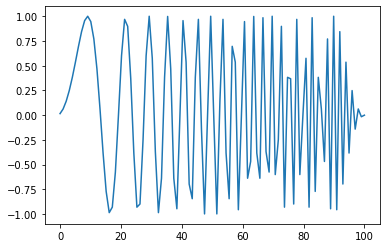

In [263]:
n = np.linspace(0,100,num=100)
sig = demo_signal('Linchirp',n.size)
plt.plot(n,sig)

In [298]:
peaks = scipy.signal.find_peaks(sig,prominence=1)[0]
s0 = np.diff(n[peaks]).min()/2
s1 = max(x)/2
s_chirp = np.linspace(s0,s1,num=100)

w_chirp,freqs_chirp = pywt.cwt(sig,s_chirp,'fbsp')
periods_chirp = 1./freqs_chirp
amp_wchirp= np.real(w_chirp*np.conjugate(w_chirp))

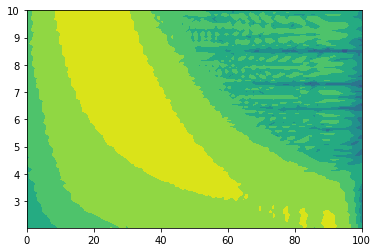

In [299]:
plt.contourf(n,periods_chirp,np.log(amp_wchirp))

In [301]:
ampt = xr.DataArray(amp_wchirp, coords = [s_chirp,n],dims=['scales','time'])
diff_amp = ampt.differentiate(coord='scales')
diff2 = diff_amp.differentiate(coord='scales')

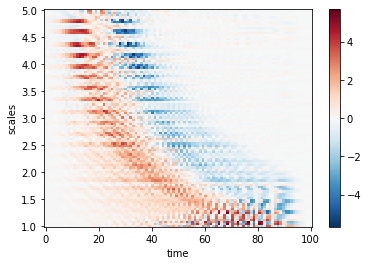

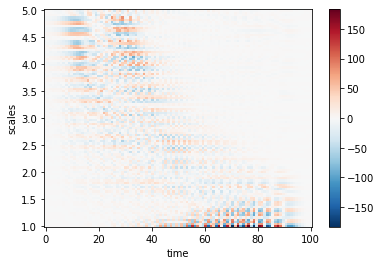

In [305]:
diff_amp.plot()
plt.figure()
diff2.plot()

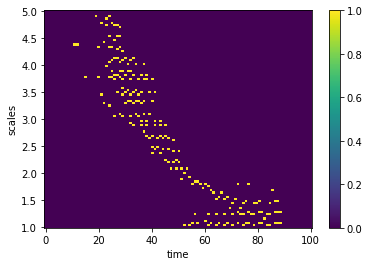

In [302]:
smax = []#np.full_like(amp,np.nan)
pmax = []
count = np.zeros_like(amp_wchirp)
#tst = scipy.signal.find_peaks(amp.isel(time=1))[0]
for i,T in enumerate(ampt.time.values[:-2]):
    I = scipy.signal.find_peaks(ampt.sel(time=T),prominence=0.1)[0]
#    smax.append(s[I])
#    pmax.append(periods[I])
    count[I,i] = 1.

count = xr.DataArray(count,coords=[s_chirp,n],dims=['scales','time'])

count.plot()